<font size="+3.8">EdgeR differential expression analysis (DEA)</font>  
<font size="+1.5">Aim: Selection of cell type markers from ABC Atlas (Yao 2023 Nature)</font>  

In [1]:
import warnings
from datetime import date

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import os
import platform

import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [4]:
# load R env
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [5]:
%%R
library(edgeR)

Lade nötiges Paket: limma
Zusätzlich: Warnmeldung:
Paket ‘limma’ wurde unter R Version 4.4.1 erstellt 


In [7]:
platform.platform()

'macOS-15.3.2-arm64-arm-64bit'

In [8]:
os.chdir("/Users/simonf/PhD/Git-mac/cellseg-benchmark")
main_dir = "./data"

In [9]:
!ls -l data

total 0
drwxr-xr-x  5 simonf  staff  160 Apr 15 17:54 ABCAtlas_Yao2023Nature


In [10]:
# Helper functions

In [11]:
%%R
# prepare and fit differential expression models using edgeR
fit_model_edgeR <- function(se,
                         method = c("LRT", "QL"),
                         cell_type_col = "cell_type",
                         include_covariate = FALSE,
                         covariate_col = "library_method",
                         min.count = 10,       # edgeR default 10
                         min.total.count = 15, # edgeR default 15
                         large.n = 10,         # edgeR default 10
                         min.prop = 0.7        # edgeR default 0.7
                         ) {
    
    method <- match.arg(method)
    stopifnot(
        is(se, "SummarizedExperiment"),
        cell_type_col %in% names(colData(se)),
        !include_covariate | covariate_col %in% names(colData(se))
    )
    
    y <- edgeR::DGEList(
        counts = assay(se, "X"),
        group = colData(se)[[cell_type_col]]
    )
    
    if (include_covariate) { y$samples$covariate <- colData(se)[[covariate_col]] }
    
    # Filter genes
    message("Initial dimensions: ", paste(dim(y), collapse = "x"))
    keep <- edgeR::filterByExpr(y, min.count = min.count, min.total.count = min.total.count, 
                                large.n = large.n, min.prop = min.prop)
    y <- y[keep, , keep.lib.sizes = FALSE]
    message("After filtering: ", paste(dim(y), collapse = "x"))
    
    # Normalize and create design matrix
    y <- edgeR::calcNormFactors(y)
    cell_type_factor <- factor(y$samples$group)
    
    design <- if (include_covariate) {
        covariate_factor <- factor(y$samples$covariate)
        design_matrix <- model.matrix(~ 0 + cell_type_factor + covariate_factor)
        colnames(design_matrix) <- c(
            levels(cell_type_factor),
            paste0("cov_", levels(covariate_factor)[-1])
        )
        design_matrix
    } else {
        design_matrix <- model.matrix(~ 0 + cell_type_factor)
        colnames(design_matrix) <- levels(cell_type_factor)
        design_matrix
    }
    
    # Fit model
    fit <- if (method == "QL") {
        y <- edgeR::estimateDisp(y, design = design)
        edgeR::glmQLFit(y, design)
    } else {
        y <- edgeR::estimateGLMRobustDisp(y, design)
        edgeR::glmFit(y, design)
    }
    
    list(fit = fit, design = design, y = y, method = method)
}

In [12]:
%%R
# one-vs-others edgeR DE testing
run_one_vs_others_test_edgeR <- function(fit, design, cell_types, method) {
    results_list <- list()
    n_cell_types <- length(cell_types)
    for (cell_type in cell_types) {
        # Create contrast: current cell type vs mean of all others
        # 1 for target, -1/(n-1) for others, 0 for possible covariates (e.g. library method)
        contrast_coef <- numeric(ncol(design))
        cell_type_cols <- seq_len(n_cell_types)
        contrast_coef[cell_type_cols] <- -1/(n_cell_types - 1)
        contrast_coef[which(cell_types == cell_type)] <- 1
        if (method == "LRT") {
            res <- glmLRT(fit, contrast=contrast_coef)
        } else if (method == "QL") {
            res <- glmQLFTest(fit, contrast=contrast_coef)
        }
        tt <- topTags(res, n = Inf)$table
        tt$test <- paste0(cell_type, "_vs_others")
        tt$cell_type <- cell_type
        results_list[[cell_type]] <- tt
    }
    return(do.call(rbind, results_list))
}

# Load formatted pseudobulks
See separate script for formatting

In [13]:
# load
setdate = "20250414"  # raw counts, pseudobulks, all merged
adata = sc.read_h5ad(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_pseudobulks_all.h5ad.gz",
    )
)

In [14]:
adata

AnnData object with n_obs × n_vars = 2767 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [15]:
adata.obs.head(2)

,cell_type_dea,donor_id,celltypedea_donorid,n_cells,library_method,batch,lib_size,log_lib_size
celltypedea_donorid,,,,,,,,
Astrocytes_352353,Astrocytes,352353,Astrocytes_352353,142,10Xv2,0,434153,12.981152
Astrocytes_352356,Astrocytes,352356,Astrocytes_352356,174,10Xv2,0,608173,13.318215


In [16]:
adata.X.max()

21642372.0

# edgeR-DEA (one-vs-others)

In [17]:
from scipy.sparse import csr_matrix

In [18]:
# format for rpy2 compatibility
if not isinstance(adata.X, csr_matrix):
    adata.X = csr_matrix(adata.X)
adata.obs["lib_size"] = adata.obs["lib_size"].astype(float)
del adata.layers

In [19]:
# clean up the cell type names to avoid Python to R conversion issues
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("/", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("+", "") for ct in adata.obs["cell_type_dea"]]

## ~ 0 + cell_type

### run

In [20]:
%%R
method = "LRT"
method = "QL"

In [21]:
%%R
# defaults
min.count = 10 # 10
min.total.count = 15 # 15
large.n = 10 # 10
min.prop = 0.7 # 0.7

In [22]:
%%time
%%R -i adata
model_fit <- fit_model_edgeR(se = adata, method = method, cell_type_col = "cell_type_dea", 
                             min.count = min.count, min.total.count = min.total.count, large.n = large.n, min.prop = min.prop)

Initial dimensions: 32285x2767
After filtering: 22290x2767


CPU times: user 12min 58s, sys: 12.8 s, total: 13min 11s
Wall time: 13min 11s


In [23]:
%%R
head(model_fit$design,2)

  ABCs Astrocytes Astroependymal BAMs Bergmann Choroid-Plexus ECs Ependymal
1    0          1              0    0        0              0   0         0
2    0          1              0    0        0              0   0         0
  Immune-Other Microglia Neurons-Dopa Neurons-Dopa-Gaba Neurons-Gaba
1            0         0            0                 0            0
2            0         0            0                 0            0
  Neurons-Glut Neurons-Glyc-Gaba Neurons-Granule-Immature Neurons-Other OECs
1            0                 0                        0             0    0
2            0                 0                        0             0    0
  OPCs Oligodendrocytes Pericytes SMCs Tanycytes VLMCs
1    0                0         0    0         0     0
2    0                0         0    0         0     0


In [24]:
%%R
dim(model_fit$y)

[1] 22290  2767


In [25]:
%%R
cell_types <- levels(as.factor(colData(adata)$cell_type_dea))
cell_types

 [1] "ABCs"                     "Astrocytes"              
 [3] "Astroependymal"           "BAMs"                    
 [5] "Bergmann"                 "Choroid-Plexus"          
 [7] "ECs"                      "Ependymal"               
 [9] "Immune-Other"             "Microglia"               
[11] "Neurons-Dopa"             "Neurons-Dopa-Gaba"       
[13] "Neurons-Gaba"             "Neurons-Glut"            
[15] "Neurons-Glyc-Gaba"        "Neurons-Granule-Immature"
[17] "Neurons-Other"            "OECs"                    
[19] "OPCs"                     "Oligodendrocytes"        
[21] "Pericytes"                "SMCs"                    
[23] "Tanycytes"                "VLMCs"                   


In [26]:
results = []

In [27]:
%%time
%%R
results <- run_one_vs_others_test_edgeR(model_fit$fit, model_fit$design,  
                                        cell_types, model_fit$method)

CPU times: user 1h 53min 13s, sys: 44.9 s, total: 1h 53min 58s
Wall time: 3h 1min 14s


### compare results

In [28]:
fdr_threshold = 1e-05

#### QL

In [29]:
%%R -o results
head(results,2)

                logFC    logCPM         F PValue FDR           test cell_type
ABCs.Slc47a1 12.75630 1.4458193  9890.767      0   0 ABCs_vs_others      ABCs
ABCs.Foxc2   12.29594 0.3763757 10178.213      0   0 ABCs_vs_others      ABCs


In [30]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "F", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [31]:
len(results["gene"].unique())

22289

In [32]:
results.head(2)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
2900040C04Rik,2900040C04Rik,Choroid-Plexus,Choroid-Plexus_vs_others,16.380588,85319.523334,2.080608,5514.004491,0.000000e+00,0.000000e+00
Cd209a,Cd209a,Immune-Other,Immune-Other_vs_others,15.282799,39863.995412,-1.631725,1947.601962,7.493459e-253,8.351460e-250


In [33]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        date.today().strftime("%Y%m%d") + "_DEA_QL_def.csv",
    )
)

In [34]:
setdate = "20250201"
setdate = "20250416"  # new cell type arrangement
results = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        setdate + "_DEA_QL_def.csv",
    )
)

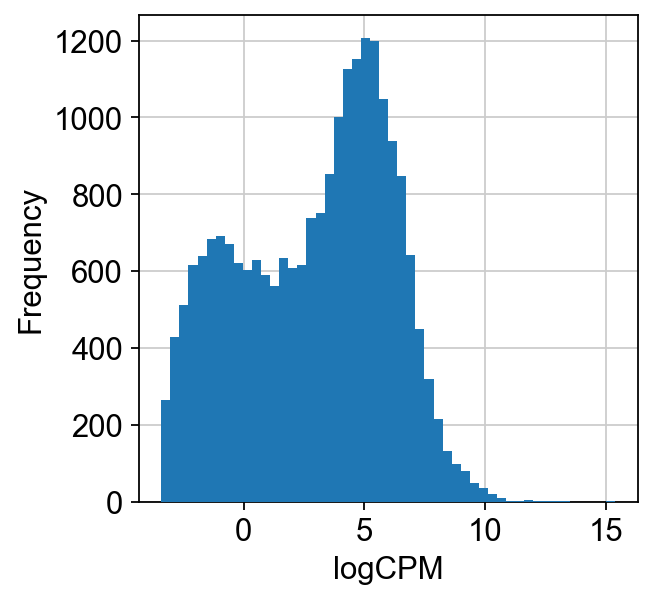

In [35]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50, zorder=3)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [36]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

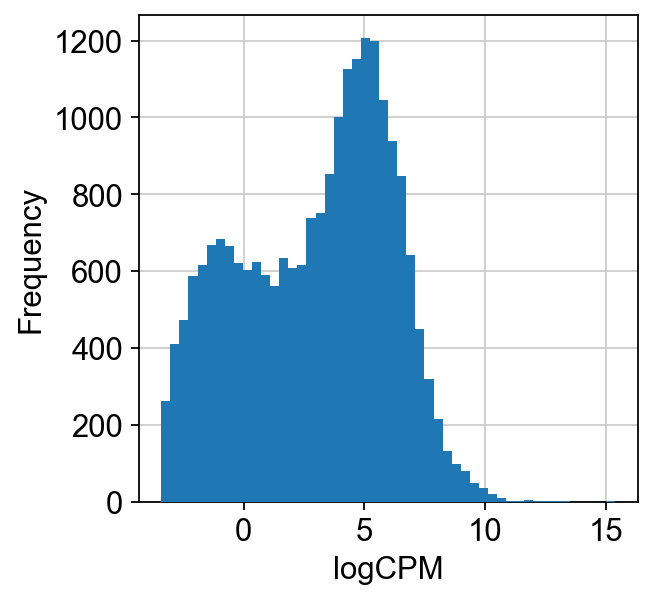

In [37]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50, zorder=3)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [38]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [39]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
23221,Ly6c1,Ly6c1,ECs,ECs_vs_others,10.610206,1563.112868,7.272990,4802.048403,0.0,0.0
23299,Adgrl4,Adgrl4,ECs,ECs_vs_others,10.481389,1429.593033,7.200510,9937.032422,0.0,0.0
22353,Flt1,Flt1,ECs,ECs_vs_others,10.374031,1327.072244,9.020702,4696.862060,0.0,0.0
23272,Cldn5,Cldn5,ECs,ECs_vs_others,10.321554,1279.667805,7.219331,5042.106670,0.0,0.0
24837,Ly6a,Ly6a,ECs,ECs_vs_others,10.226087,1197.730217,6.251820,8211.548168,0.0,0.0
22766,Slco1a4,Slco1a4,ECs,ECs_vs_others,10.182019,1161.697471,7.834378,3984.131688,0.0,0.0
26310,Cdh5,Cdh5,ECs,ECs_vs_others,9.970590,1003.336749,5.558502,8590.404049,0.0,0.0
27945,Cd93,Cd93,ECs,ECs_vs_others,9.873501,938.036852,4.882786,12765.938030,0.0,0.0
27959,Ctla2a,Ctla2a,ECs,ECs_vs_others,9.730020,849.235172,4.874609,10411.841019,0.0,0.0
26773,Zfp366,Zfp366,ECs,ECs_vs_others,9.585086,768.065943,5.364947,8821.387794,0.0,0.0


In [40]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
23272,Cldn5,Cldn5,ECs,ECs_vs_others,10.321554,1279.667805,7.219331,5042.106670,0.0,0.0
26310,Cdh5,Cdh5,ECs,ECs_vs_others,9.970590,1003.336749,5.558502,8590.404049,0.0,0.0
27303,Kdr,Kdr,ECs,ECs_vs_others,8.464363,353.205332,5.152081,5801.591567,0.0,0.0


In [41]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
97167,Higd1b,Higd1b,Pericytes,Pericytes_vs_others,11.431555,2762.109076,6.372880,11754.826894,0.000000e+00,0.000000e+00
96903,Abcc9,Abcc9,Pericytes,Pericytes_vs_others,10.867419,1868.182058,6.530359,7140.750543,0.000000e+00,0.000000e+00
99609,Carmn,Carmn,Pericytes,Pericytes_vs_others,10.617096,1570.595056,5.115795,5568.065109,0.000000e+00,0.000000e+00
98430,Ndufa4l2,Ndufa4l2,Pericytes,Pericytes_vs_others,10.341342,1297.340681,5.671921,8936.310318,0.000000e+00,0.000000e+00
96520,Slc38a11,Slc38a11,Pericytes,Pericytes_vs_others,10.087116,1087.738380,6.780887,5352.338596,0.000000e+00,0.000000e+00
97778,Tbx3os1,Tbx3os1,Pericytes,Pericytes_vs_others,9.796571,889.327307,6.024627,4741.278200,0.000000e+00,0.000000e+00
96137,Vtn,Vtn,Pericytes,Pericytes_vs_others,9.559103,754.356746,7.084063,5512.853569,0.000000e+00,0.000000e+00
95121,Rgs5,Rgs5,Pericytes,Pericytes_vs_others,9.451878,700.323826,9.017142,4513.508860,0.000000e+00,0.000000e+00
96465,Slc6a20a,Slc6a20a,Pericytes,Pericytes_vs_others,9.164550,573.857853,6.827340,9007.552803,0.000000e+00,0.000000e+00
95984,Adap2,Adap2,Pericytes,Pericytes_vs_others,8.862261,465.378594,7.226784,5454.122865,0.000000e+00,0.000000e+00


In [42]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
96137,Vtn,Vtn,Pericytes,Pericytes_vs_others,9.559103,754.356746,7.084063,5512.853569,0.0,0.0
95820,Atp13a5,Atp13a5,Pericytes,Pericytes_vs_others,8.302249,315.664611,7.415078,5904.751122,0.0,0.0


In [43]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
100679,Acta2,Acta2,SMCs,SMCs_vs_others,12.697755,6643.623620,7.462944,8840.957649,0.000000e+00,0.000000e+00
101209,Myh11,Myh11,SMCs,SMCs_vs_others,12.065254,4285.519109,6.959398,10673.620921,0.000000e+00,0.000000e+00
100978,Tagln,Tagln,SMCs,SMCs_vs_others,11.654245,3223.125652,7.153869,9924.696606,0.000000e+00,0.000000e+00
104634,Carmn,Carmn,SMCs,SMCs_vs_others,10.829919,1820.247494,5.115795,5651.944347,0.000000e+00,0.000000e+00
101445,Slc38a11,Slc38a11,SMCs,SMCs_vs_others,10.505098,1453.281371,6.780887,5769.780233,0.000000e+00,0.000000e+00
102103,Higd1b,Higd1b,SMCs,SMCs_vs_others,10.359036,1313.350541,6.372880,6495.670081,0.000000e+00,0.000000e+00
104279,Pln,Pln,SMCs,SMCs_vs_others,10.298789,1259.633711,5.281014,6618.232454,0.000000e+00,0.000000e+00
100615,Myl9,Myl9,SMCs,SMCs_vs_others,9.809278,897.195261,7.547224,13344.097699,0.000000e+00,0.000000e+00
102278,Crispld2,Crispld2,SMCs,SMCs_vs_others,9.671174,815.292258,6.282493,5425.954956,0.000000e+00,0.000000e+00
100024,Rgs5,Rgs5,SMCs,SMCs_vs_others,9.403072,677.028309,9.017142,4338.290794,0.000000e+00,0.000000e+00


In [44]:
SMCs[SMCs.gene.isin(["Acta2", "Tagln"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
100679,Acta2,Acta2,SMCs,SMCs_vs_others,12.697755,6643.623620,7.462944,8840.957649,0.0,0.0
100978,Tagln,Tagln,SMCs,SMCs_vs_others,11.654245,3223.125652,7.153869,9924.696606,0.0,0.0


In [45]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
94908,A330049N07Rik,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.720689,843.760001,4.887916,7535.055594,0.0,0.0
93071,C030029H02Rik,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.556751,753.128034,5.600123,7374.002989,0.0,0.0
91464,9630013A20Rik,9630013A20Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.527597,738.061505,6.326123,5429.129483,0.0,0.0
89973,Fa2h,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.369198,661.316881,7.253834,9098.075169,0.0,0.0
91477,Opalin,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.341453,648.720554,6.317716,11500.933334,0.0,0.0
93010,Enpp6,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.225907,598.790268,5.621420,8299.829373,0.0,0.0
93550,A230001M10Rik,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.222234,597.267591,5.418435,10698.598881,0.0,0.0
89978,Ermn,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,8.970880,501.769303,7.245504,8740.172378,0.0,0.0
88926,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.820128,451.983965,12.994583,2866.131180,0.0,0.0
89233,Cldn11,Cldn11,Oligodendrocytes,Oligodendrocytes_vs_others,8.772631,437.345824,8.378884,8947.036729,0.0,0.0


In [46]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
88926,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.820128,451.983965,12.994583,2866.131180,0.000000e+00,0.000000e+00
89508,Mag,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.305692,316.418902,7.788082,6554.292678,0.000000e+00,0.000000e+00
88972,Mbp,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,5.519801,45.880234,10.001906,1081.210658,3.046925e-200,2.896203e-199


In [47]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
108801,Dcn,Dcn,VLMCs,VLMCs_vs_others,10.893612,1902.409892,6.626491,3113.417051,0.0,0.0
111806,Tbx18,Tbx18,VLMCs,VLMCs_vs_others,10.809160,1794.243913,4.992794,11955.652222,0.0,0.0
108969,Igf2,Igf2,VLMCs,VLMCs_vs_others,10.635406,1590.655462,6.511727,7613.427541,0.0,0.0
110437,Lama1,Lama1,VLMCs,VLMCs_vs_others,10.078006,1080.891537,5.685535,3672.859561,0.0,0.0
109760,Cemip,Cemip,VLMCs,VLMCs_vs_others,9.218369,595.669923,6.037456,7840.283974,0.0,0.0
111460,Lamc3,Lamc3,VLMCs,VLMCs_vs_others,8.762585,434.311164,5.171905,7883.193639,0.0,0.0
107351,Apod,Apod,VLMCs,VLMCs_vs_others,8.661209,404.840187,8.451173,3948.593294,0.0,0.0
108524,Slc6a20a,Slc6a20a,VLMCs,VLMCs_vs_others,8.530030,369.653670,6.827340,6171.452363,0.0,0.0
107654,Pdgfra,Pdgfra,VLMCs,VLMCs_vs_others,8.514027,365.575953,7.718048,6108.037454,0.0,0.0
107134,Ptgds,Ptgds,VLMCs,VLMCs_vs_others,8.460434,352.244693,9.998911,2237.056407,0.0,0.0


In [48]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
7767,Atp13a4,Atp13a4,Astrocytes,Astrocytes_vs_others,7.943748,246.210426,5.029841,7110.952659,0.0,0.0
5953,Gm12239,Gm12239,Astrocytes,Astrocytes_vs_others,7.616582,196.254564,5.799459,3009.459185,0.0,0.0
7323,Gm20713,Gm20713,Astrocytes,Astrocytes_vs_others,7.307681,158.427775,5.223751,4149.631602,0.0,0.0
5750,Gm6145,Gm6145,Astrocytes,Astrocytes_vs_others,7.260748,153.356770,5.898566,7111.176961,0.0,0.0
2436,Gpc5,Gpc5,Astrocytes,Astrocytes_vs_others,7.204746,147.517844,10.001406,2415.266781,0.0,0.0
7027,Agt,Agt,Astrocytes,Astrocytes_vs_others,7.176162,144.623875,5.344366,4215.981581,0.0,0.0
7180,Etnppl,Etnppl,Astrocytes,Astrocytes_vs_others,6.947494,123.425241,5.285362,5061.082733,0.0,0.0
8099,Itih3,Itih3,Astrocytes,Astrocytes_vs_others,6.875030,117.378947,4.892653,4302.257958,0.0,0.0
8469,Eva1a,Eva1a,Astrocytes,Astrocytes_vs_others,6.843951,114.877407,4.729105,8148.868235,0.0,0.0
6537,Slc7a10,Slc7a10,Astrocytes,Astrocytes_vs_others,6.776723,109.647054,5.552541,5927.246361,0.0,0.0


In [49]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
4046,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,6.751900,107.776620,6.812728,4706.498742,0.000000e+00,0.000000e+00
7628,Gfap,Gfap,Astrocytes,Astrocytes_vs_others,5.565925,47.370768,5.094349,4192.213930,0.000000e+00,0.000000e+00
3746,Htra1,Htra1,Astrocytes,Astrocytes_vs_others,5.491393,44.985658,7.019223,2990.564051,0.000000e+00,0.000000e+00
3008,Aldoc,Aldoc,Astrocytes,Astrocytes_vs_others,4.343219,20.297337,7.812475,1820.523118,1.905394e-307,4.447248e-306


#### LRT

In [29]:
%%R -o results
head(results,2)

                logFC    logCPM        LR PValue FDR           test cell_type
ABCs.Slc47a1 13.48315  1.556481 14341.028      0   0 ABCs_vs_others      ABCs
ABCs.Lypd2   12.99211 -2.675636  6904.334      0   0 ABCs_vs_others      ABCs


In [30]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "LR", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [31]:
len(results["gene"].unique())

22289

In [32]:
results.head(2)

,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
Ttr,Ttr,Choroid-Plexus,Choroid-Plexus_vs_others,18.310600,325117.136485,8.250640,1998.755053,0.0,0.0
2900040C04Rik,2900040C04Rik,Choroid-Plexus,Choroid-Plexus_vs_others,17.786782,226128.358680,2.108874,68565.332488,0.0,0.0


In [33]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        date.today().strftime("%Y%m%d") + "_DEA_LRT_def.csv",
    )
)

In [35]:
setdate = "20250201"
setdate = "20250416"  # new cell type arrangement
results = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        setdate + "_DEA_LRT_def.csv",
    )
)

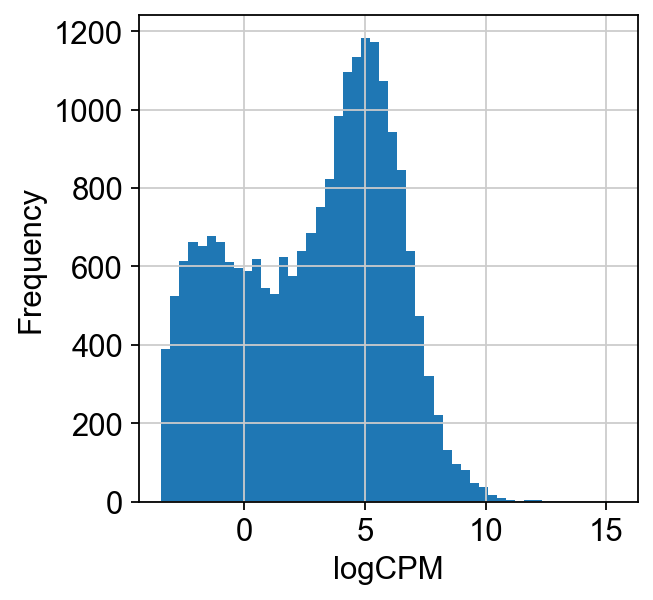

In [36]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50, zorder=3)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [37]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

In [38]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [39]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
26088,Ly6c1,Ly6c1,ECs,ECs_vs_others,11.072435,2153.450764,7.370769,2508.205445,0.0,0.0
26193,Adgrl4,Adgrl4,ECs,ECs_vs_others,10.934222,1956.720410,7.274887,3890.327587,0.0,0.0
25269,Flt1,Flt1,ECs,ECs_vs_others,10.855394,1852.674857,9.142353,2913.803346,0.0,0.0
26197,Cldn5,Cldn5,ECs,ECs_vs_others,10.792902,1774.136818,7.273790,2280.329282,0.0,0.0
27747,Ly6a,Ly6a,ECs,ECs_vs_others,10.791722,1772.687154,6.310198,2972.863892,0.0,0.0
25664,Slco1a4,Slco1a4,ECs,ECs_vs_others,10.654970,1612.373567,7.945988,1796.427024,0.0,0.0
29261,Cdh5,Cdh5,ECs,ECs_vs_others,10.583924,1534.894986,5.620529,13776.610283,0.0,0.0
31124,Ctla2a,Ctla2a,ECs,ECs_vs_others,10.332863,1289.738771,4.862469,12575.048043,0.0,0.0
31130,Cd93,Cd93,ECs,ECs_vs_others,10.273314,1237.586828,4.860670,8326.460799,0.0,0.0
29812,Zfp366,Zfp366,ECs,ECs_vs_others,10.044499,1056.076644,5.403921,11953.070722,0.0,0.0


In [40]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
26197,Cldn5,Cldn5,ECs,ECs_vs_others,10.792902,1774.136818,7.273790,2280.329282,0.0,0.0
29261,Cdh5,Cdh5,ECs,ECs_vs_others,10.583924,1534.894986,5.620529,13776.610283,0.0,0.0
30447,Kdr,Kdr,ECs,ECs_vs_others,8.794193,443.931318,5.151553,5562.314094,0.0,0.0


In [41]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
106702,Higd1b,Higd1b,Pericytes,Pericytes_vs_others,12.335744,5169.265333,6.273738,6569.006040,0.0,0.0
106194,Abcc9,Abcc9,Pericytes,Pericytes_vs_others,11.457094,2811.440929,6.547952,5563.794488,0.0,0.0
109253,Carmn,Carmn,Pericytes,Pericytes_vs_others,11.433061,2764.995250,5.036020,11332.859576,0.0,0.0
108272,Ndufa4l2,Ndufa4l2,Pericytes,Pericytes_vs_others,10.900090,1910.970150,5.488682,20415.806273,0.0,0.0
105758,Slc38a11,Slc38a11,Pericytes,Pericytes_vs_others,10.813408,1799.534710,6.828577,3041.908033,0.0,0.0
107207,Tbx3os1,Tbx3os1,Pericytes,Pericytes_vs_others,10.284018,1246.803048,5.997262,11124.199977,0.0,0.0
105378,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.019294,1037.786882,7.123105,4068.424385,0.0,0.0
104343,Rgs5,Rgs5,Pericytes,Pericytes_vs_others,9.953081,991.233608,9.100388,1911.208387,0.0,0.0
105835,Slc6a20a,Slc6a20a,Pericytes,Pericytes_vs_others,9.444914,696.951442,6.772741,11978.732060,0.0,0.0
105194,Adap2,Adap2,Pericytes,Pericytes_vs_others,9.420573,685.291187,7.304522,8093.911922,0.0,0.0


In [42]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
105378,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.019294,1037.786882,7.123105,4068.424385,0.0,0.0
105050,Atp13a5,Atp13a5,Pericytes,Pericytes_vs_others,8.492920,360.266298,7.444602,9173.553243,0.0,0.0


In [43]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
110167,Acta2,Acta2,SMCs,SMCs_vs_others,13.301110,10093.295768,7.530849,5853.414417,0.0,0.0
110689,Myh11,Myh11,SMCs,SMCs_vs_others,12.448592,5589.843771,7.014900,20066.432575,0.0,0.0
110500,Tagln,Tagln,SMCs,SMCs_vs_others,12.015350,4139.814178,7.179595,8656.854500,0.0,0.0
114502,Carmn,Carmn,SMCs,SMCs_vs_others,11.646445,3205.747866,5.036020,11485.417454,0.0,0.0
111897,Higd1b,Higd1b,SMCs,SMCs_vs_others,11.278659,2484.360991,6.273738,10113.669139,0.0,0.0
110946,Slc38a11,Slc38a11,SMCs,SMCs_vs_others,11.242417,2422.727995,6.828577,3151.548842,0.0,0.0
114177,Pln,Pln,SMCs,SMCs_vs_others,10.578026,1528.632165,5.175636,8898.413346,0.0,0.0
110091,Myl9,Myl9,SMCs,SMCs_vs_others,9.989612,1016.653531,7.614873,10747.780884,0.0,0.0
112075,Crispld2,Crispld2,SMCs,SMCs_vs_others,9.928856,974.728112,6.179948,2826.073368,0.0,0.0
109519,Rgs5,Rgs5,SMCs,SMCs_vs_others,9.907695,960.535171,9.100388,1877.821142,0.0,0.0


In [44]:
SMCs[SMCs.gene.isin(["Vtn", "Kcnj8"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
110564,Vtn,Vtn,SMCs,SMCs_vs_others,7.219343,149.017985,7.123105,2882.476794,0.0,0.0


In [45]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
103614,A330049N07Rik,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,10.185542,1164.537925,5.042235,5285.075744,0.0,0.0
101729,C030029H02Rik,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.999193,1023.427679,5.759401,8746.771730,0.0,0.0
98810,Fa2h,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.641826,798.874753,7.393182,8678.124030,0.0,0.0
102232,A230001M10Rik,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.638462,797.014413,5.570053,9574.524770,0.0,0.0
100307,Opalin,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.608625,780.700131,6.412908,5577.971852,0.0,0.0
102060,Enpp6,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.586918,769.041839,5.631885,10842.989962,0.0,0.0
98841,Ermn,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,9.354588,654.653640,7.366059,4277.791199,0.0,0.0
98227,St18,St18,Oligodendrocytes,Oligodendrocytes_vs_others,9.083584,542.539349,8.308184,4513.358798,0.0,0.0
97886,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.079873,541.145568,13.089111,2910.493742,0.0,0.0
102415,9630013A20Rik,9630013A20Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.059248,533.464262,5.497034,4269.818500,0.0,0.0


In [46]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
97886,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.079873,541.145568,13.089111,2910.493742,0.0,0.0
98432,Mag,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.479560,356.945609,7.883093,4043.434527,0.0,0.0
97928,Mbp,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,6.040362,65.815816,10.030403,1861.400016,0.0,0.0


In [47]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
119362,Dcn,Dcn,VLMCs,VLMCs_vs_others,11.937800,3923.158524,6.550840,2324.750810,0.0,0.0
119371,Igf2,Igf2,VLMCs,VLMCs_vs_others,11.502145,2900.618890,6.548518,6704.974839,0.0,0.0
121233,Lama1,Lama1,VLMCs,VLMCs_vs_others,10.628450,1583.005073,5.564069,3573.179602,0.0,0.0
120536,Cemip,Cemip,VLMCs,VLMCs_vs_others,9.515545,731.921654,5.909105,6377.140338,0.0,0.0
122265,Lamc3,Lamc3,VLMCs,VLMCs_vs_others,9.205913,590.548966,5.050895,16990.891232,0.0,0.0
117702,Apod,Apod,VLMCs,VLMCs_vs_others,9.055063,531.918947,8.486277,3792.597173,0.0,0.0
117982,Pdgfra,Pdgfra,VLMCs,VLMCs_vs_others,8.853973,462.712887,7.819986,9592.023982,0.0,0.0
119015,Slc6a20a,Slc6a20a,VLMCs,VLMCs_vs_others,8.794391,443.992483,6.772741,10840.964915,0.0,0.0
120182,Bgn,Bgn,VLMCs,VLMCs_vs_others,8.694060,414.164603,6.072187,5189.519978,0.0,0.0
117509,Ptgds,Ptgds,VLMCs,VLMCs_vs_others,8.550270,374.876135,9.792004,2539.649548,0.0,0.0


In [48]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
8385,Atp13a4,Atp13a4,Astrocytes,Astrocytes_vs_others,8.121188,278.433300,5.039859,7256.910871,0.0,0.0
6701,Gm12239,Gm12239,Astrocytes,Astrocytes_vs_others,7.962802,249.483803,5.713411,2751.544691,0.0,0.0
7884,Gm20713,Gm20713,Astrocytes,Astrocytes_vs_others,7.741863,214.058758,5.236459,2584.706412,0.0,0.0
6222,Gm6145,Gm6145,Astrocytes,Astrocytes_vs_others,7.555857,188.165269,5.936253,5948.737276,0.0,0.0
2896,Gpc5,Gpc5,Astrocytes,Astrocytes_vs_others,7.462329,176.353859,10.057424,2784.121827,0.0,0.0
7711,Etnppl,Etnppl,Astrocytes,Astrocytes_vs_others,7.327506,160.619852,5.306065,2696.146572,0.0,0.0
8081,Agt,Agt,Astrocytes,Astrocytes_vs_others,7.288144,156.296737,5.156107,1812.586188,0.0,0.0
8993,Eva1a,Eva1a,Astrocytes,Astrocytes_vs_others,7.137036,140.754376,4.778376,10137.685310,0.0,0.0
5910,Gjb6,Gjb6,Astrocytes,Astrocytes_vs_others,7.124701,139.556092,6.072872,2892.975617,0.0,0.0
9396,Itih3,Itih3,Astrocytes,Astrocytes_vs_others,7.017965,129.603868,4.606441,2375.607049,0.0,0.0


In [49]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
4589,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,6.981859,126.400561,6.767451,2127.415523,0.0,0.0
8706,Gfap,Gfap,Astrocytes,Astrocytes_vs_others,5.804303,55.881650,4.900453,2866.780911,0.0,0.0
4161,Htra1,Htra1,Astrocytes,Astrocytes_vs_others,5.770730,54.596265,7.065886,3265.673825,0.0,0.0
3466,Aldoc,Aldoc,Astrocytes,Astrocytes_vs_others,4.526902,23.053304,7.822129,1523.771688,0.0,0.0


## ~ 0 + cell_type + library_method

Including library_method (10Xv2, 10Xv3, 10X_Multi) as covariate

### run

In [20]:
%%R
method = "LRT"
method = "QL"

In [21]:
%%R
# defaults
min.count = 10 # 10
min.total.count = 15 # 15
large.n = 10 # 10
min.prop = 0.7 # 0.7

In [22]:
%%time
%%R -i adata
model_fit <- fit_model_edgeR(se = adata, method = method, cell_type_col = "cell_type_dea", 
                             include_covariate = TRUE, covariate_col = "library_method",
                             min.count = min.count, min.total.count = min.total.count, large.n = large.n, min.prop = min.prop)

Initial dimensions: 32285x2767
After filtering: 22290x2767


CPU times: user 1h 14min 20s, sys: 51.8 s, total: 1h 15min 12s
Wall time: 1h 16min 55s


In [23]:
%%R
head(model_fit$design,2)

  ABCs Astrocytes Astroependymal BAMs Bergmann Choroid-Plexus ECs Ependymal
1    0          1              0    0        0              0   0         0
2    0          1              0    0        0              0   0         0
  Immune-Other Microglia Neurons-Dopa Neurons-Dopa-Gaba Neurons-Gaba
1            0         0            0                 0            0
2            0         0            0                 0            0
  Neurons-Glut Neurons-Glyc-Gaba Neurons-Granule-Immature Neurons-Other OECs
1            0                 0                        0             0    0
2            0                 0                        0             0    0
  OPCs Oligodendrocytes Pericytes SMCs Tanycytes VLMCs cov_10Xv3
1    0                0         0    0         0     0         0
2    0                0         0    0         0     0         0
  cov_10xRSeq_Mult
1                0
2                0


In [24]:
%%R
cell_types <- levels(as.factor(colData(adata)$cell_type_dea))
cell_types

 [1] "ABCs"                     "Astrocytes"              
 [3] "Astroependymal"           "BAMs"                    
 [5] "Bergmann"                 "Choroid-Plexus"          
 [7] "ECs"                      "Ependymal"               
 [9] "Immune-Other"             "Microglia"               
[11] "Neurons-Dopa"             "Neurons-Dopa-Gaba"       
[13] "Neurons-Gaba"             "Neurons-Glut"            
[15] "Neurons-Glyc-Gaba"        "Neurons-Granule-Immature"
[17] "Neurons-Other"            "OECs"                    
[19] "OPCs"                     "Oligodendrocytes"        
[21] "Pericytes"                "SMCs"                    
[23] "Tanycytes"                "VLMCs"                   


In [25]:
%%time
%%R
results <- run_one_vs_others_test_edgeR(model_fit$fit, model_fit$design,  
                                        cell_types, model_fit$method)

CPU times: user 2h 14min 57s, sys: 1min 12s, total: 2h 16min 9s
Wall time: 2h 59min 38s


### compare results

In [26]:
fdr_threshold = 1e-05

#### QL

In [27]:
%%R -o results
head(results,2)

                logFC    logCPM        F PValue FDR           test cell_type
ABCs.Slc47a1 12.78402 1.3238899 11031.94      0   0 ABCs_vs_others      ABCs
ABCs.Foxc2   12.31256 0.2162154 11010.05      0   0 ABCs_vs_others      ABCs


In [28]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "F", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [29]:
len(results["gene"].unique())

22289

In [30]:
results.head()

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
Ttr,Ttr,Choroid-Plexus,Choroid-Plexus_vs_others,135.181785,4.940513e+40,8.132041,799.587782,4.256697e-158,6.005176e-156
2900040C04Rik,2900040C04Rik,Choroid-Plexus,Choroid-Plexus_vs_others,127.661904,2.691921e+38,2.018167,802.704368,2.537594e-145,3.041020e-143
Cd74,Cd74,Immune-Other,Immune-Other_vs_others,100.914121,2.388787e+30,3.470628,4051.173435,0.000000e+00,0.000000e+00
H2-Aa,H2-Aa,Immune-Other,Immune-Other_vs_others,74.894885,3.512424e+22,-0.561902,2914.819092,0.000000e+00,0.000000e+00
Foxd3,Foxd3,OECs,OECs_vs_others,15.607086,4.991155e+04,-0.932488,1581.746244,2.292856e-227,5.110777e-225


In [31]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        date.today().strftime("%Y%m%d") + "_DEA_QL_def_incllib.csv",
    )
)

In [32]:
setdate = "20250130"
setdate = "20250416"
results = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        setdate + "_DEA_QL_def_incllib.csv",
    ),
    index_col=0,
)

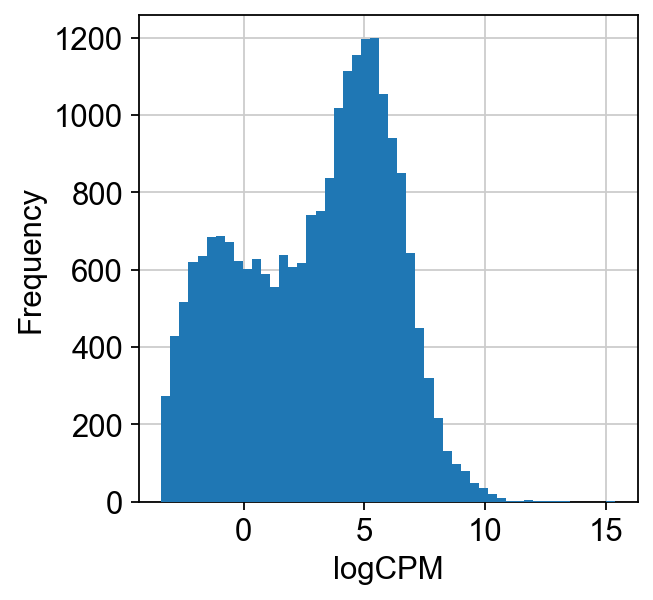

In [33]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50, zorder=3)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [34]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

In [35]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [36]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
24297,Ly6c1,ECs,ECs_vs_others,10.904053,1916.227069,7.269036,8283.597095,0.0,0.0
24373,Adgrl4,ECs,ECs_vs_others,10.708818,1673.691660,7.197116,11276.770201,0.0,0.0
23826,Slco1a4,ECs,ECs_vs_others,10.586765,1537.920496,7.832583,7465.815393,0.0,0.0
23403,Flt1,ECs,ECs_vs_others,10.554420,1503.824175,9.019446,5182.745096,0.0,0.0
24347,Cldn5,ECs,ECs_vs_others,10.526408,1474.906891,7.211920,5630.380827,0.0,0.0
25968,Ly6a,ECs,ECs_vs_others,10.492815,1440.960744,6.243084,9462.996571,0.0,0.0
27489,Cdh5,ECs,ECs_vs_others,10.155254,1140.344752,5.550133,10106.094264,0.0,0.0
29150,Cd93,ECs,ECs_vs_others,9.997408,1022.161991,4.870895,13964.910448,0.0,0.0
25514,Mecom,ECs,ECs_vs_others,9.969563,1002.622508,6.466483,2673.862095,0.0,0.0
29166,Ctla2a,ECs,ECs_vs_others,9.847603,921.348296,4.863907,11243.376871,0.0,0.0


In [37]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
24347,Cldn5,ECs,ECs_vs_others,10.526408,1474.906891,7.211920,5630.380827,0.0,0.0
27489,Cdh5,ECs,ECs_vs_others,10.155254,1140.344752,5.550133,10106.094264,0.0,0.0
28494,Kdr,ECs,ECs_vs_others,8.540914,372.452816,5.142400,6203.358921,0.0,0.0


In [38]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
100202,Higd1b,Pericytes,Pericytes_vs_others,11.333685,2580.946664,6.357599,13939.340134,0.000000e+00,0.000000e+00
99906,Abcc9,Pericytes,Pericytes_vs_others,10.909994,1924.135097,6.522852,7379.878788,0.000000e+00,0.000000e+00
102709,Carmn,Pericytes,Pericytes_vs_others,10.598986,1551.002968,5.098721,6037.815478,0.000000e+00,0.000000e+00
101514,Ndufa4l2,Pericytes,Pericytes_vs_others,10.239778,1209.150799,5.651601,18113.850156,0.000000e+00,0.000000e+00
99505,Slc38a11,Pericytes,Pericytes_vs_others,10.095746,1094.265019,6.775768,5432.695163,0.000000e+00,0.000000e+00
100821,Tbx3os1,Pericytes,Pericytes_vs_others,9.776360,876.955771,6.013877,5130.048158,0.000000e+00,0.000000e+00
99114,Vtn,Pericytes,Pericytes_vs_others,9.587987,769.611741,7.077353,6269.217897,0.000000e+00,0.000000e+00
98069,Rgs5,Pericytes,Pericytes_vs_others,9.444664,696.830607,9.015605,4762.912107,0.000000e+00,0.000000e+00
99453,Slc6a20a,Pericytes,Pericytes_vs_others,9.162885,573.196182,6.819851,8084.423157,0.000000e+00,0.000000e+00
98952,Adap2,Pericytes,Pericytes_vs_others,8.899700,477.613465,7.221759,6045.042824,0.000000e+00,0.000000e+00


In [39]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
99114,Vtn,Pericytes,Pericytes_vs_others,9.587987,769.611741,7.077353,6269.217897,0.0,0.0
98780,Atp13a5,Pericytes,Pericytes_vs_others,8.300681,315.321723,7.410895,6172.922463,0.0,0.0


In [40]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
103755,Acta2,SMCs,SMCs_vs_others,12.711541,6707.412396,7.460826,9478.813885,0.0,0.0
104297,Myh11,SMCs,SMCs_vs_others,12.072483,4307.045364,6.956723,18098.623877,0.0,0.0
104061,Tagln,SMCs,SMCs_vs_others,11.665496,3248.360827,7.151679,15980.579323,0.0,0.0
107857,Carmn,SMCs,SMCs_vs_others,10.845757,1840.340101,5.098721,9195.926241,0.0,0.0
104544,Slc38a11,SMCs,SMCs_vs_others,10.505119,1453.301842,6.775768,5843.225509,0.0,0.0
105248,Higd1b,SMCs,SMCs_vs_others,10.387794,1339.793054,6.357599,8056.125828,0.0,0.0
107481,Pln,SMCs,SMCs_vs_others,10.345181,1300.797620,5.268963,7222.128922,0.0,0.0
103691,Myl9,SMCs,SMCs_vs_others,9.825267,907.193524,7.543328,14863.940629,0.0,0.0
105406,Crispld2,SMCs,SMCs_vs_others,9.715135,840.518295,6.274791,4218.600703,0.0,0.0
103089,Rgs5,SMCs,SMCs_vs_others,9.393591,672.593444,9.015605,4439.421457,0.0,0.0


In [41]:
SMCs[SMCs.gene.isin(["Vtn", "Kcnj8"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
104149,Vtn,SMCs,SMCs_vs_others,6.785657,110.328158,7.077353,4933.770774,0.0,0.0


In [42]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
97827,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.832213,911.572027,4.902045,8481.874208,0.0,0.0
95973,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.550914,750.087108,5.608748,11841.081708,0.0,0.0
92832,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.543034,746.001137,7.258475,10086.436948,0.0,0.0
96442,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.300689,630.647020,5.430576,11691.920520,0.0,0.0
94382,9630013A20Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.291491,626.638952,6.318083,9497.092915,0.0,0.0
94374,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.236480,603.194601,6.321251,8951.070810,0.0,0.0
95927,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.167347,574.971536,5.623301,14752.654505,0.0,0.0
92144,St18,Oligodendrocytes,Oligodendrocytes_vs_others,9.091754,545.620443,8.213497,4760.538424,0.0,0.0
92838,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,9.080060,541.215752,7.250892,9473.673636,0.0,0.0
91756,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.963158,499.090542,12.994722,3244.243167,0.0,0.0


In [43]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
91756,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,8.963158,499.090542,12.994722,3244.243167,0.000000e+00,0.000000e+00
92363,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.487077,358.810255,7.791523,7700.276910,0.000000e+00,0.000000e+00
91804,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,5.930819,61.003463,10.002638,1317.639206,5.822995e-236,5.817775e-235


In [44]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
112300,Dcn,VLMCs,VLMCs_vs_others,10.936982,1960.467767,6.615786,3202.831270,0.0,0.0
115409,Tbx18,VLMCs,VLMCs_vs_others,10.822826,1811.320400,4.970814,12935.741058,0.0,0.0
112471,Igf2,VLMCs,VLMCs_vs_others,10.710735,1675.917201,6.504127,8725.051869,0.0,0.0
113996,Lama1,VLMCs,VLMCs_vs_others,10.063870,1070.352271,5.671971,6023.905660,0.0,0.0
113305,Cemip,VLMCs,VLMCs_vs_others,9.212405,593.212393,6.026608,5235.200884,0.0,0.0
115051,Lamc3,VLMCs,VLMCs_vs_others,8.761608,434.017210,5.156042,8289.641478,0.0,0.0
110766,Apod,VLMCs,VLMCs_vs_others,8.689846,412.956451,8.450532,5123.479441,0.0,0.0
110542,Ptgds,VLMCs,VLMCs_vs_others,8.650568,401.865126,9.998802,3293.052107,0.0,0.0
111993,Slc6a20a,VLMCs,VLMCs_vs_others,8.569589,379.929880,6.819851,7368.123835,0.0,0.0
111081,Pdgfra,VLMCs,VLMCs_vs_others,8.509140,364.339489,7.718516,6485.874663,0.0,0.0


In [45]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
8086,Atp13a4,Astrocytes,Astrocytes_vs_others,8.076479,269.937054,5.022579,8521.157399,0.0,0.0
6243,Gm12239,Astrocytes,Astrocytes_vs_others,7.885896,236.532796,5.796532,3305.743648,0.0,0.0
7631,Gm20713,Astrocytes,Astrocytes_vs_others,7.463188,176.458798,5.218996,4382.935427,0.0,0.0
6028,Gm6145,Astrocytes,Astrocytes_vs_others,7.354228,163.622524,5.893574,7421.708227,0.0,0.0
2639,Gpc5,Astrocytes,Astrocytes_vs_others,7.332141,161.136679,10.001288,2618.262820,0.0,0.0
7339,Agt,Astrocytes,Astrocytes_vs_others,7.207218,147.770872,5.335525,4332.330138,0.0,0.0
7489,Etnppl,Astrocytes,Astrocytes_vs_others,7.133304,140.390725,5.279249,5773.530709,0.0,0.0
8431,Itih3,Astrocytes,Astrocytes_vs_others,7.016730,129.493001,4.884387,4850.154122,0.0,0.0
4272,Aqp4,Astrocytes,Astrocytes_vs_others,6.993930,127.462590,6.808859,5640.447862,0.0,0.0
8806,Eva1a,Astrocytes,Astrocytes_vs_others,6.978019,126.064544,4.720928,9303.152280,0.0,0.0


In [46]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR
4272,Aqp4,Astrocytes,Astrocytes_vs_others,6.993930,127.462590,6.808859,5640.447862,0.0,0.0
7976,Gfap,Astrocytes,Astrocytes_vs_others,5.923597,60.698834,5.080132,4784.374622,0.0,0.0
3969,Htra1,Astrocytes,Astrocytes_vs_others,5.629950,49.520379,7.017593,3754.732064,0.0,0.0
3216,Aldoc,Astrocytes,Astrocytes_vs_others,4.671689,25.486980,7.812011,2637.455245,0.0,0.0


#### LRT

In [28]:
%%R -o results
head(results,2)

                logFC    logCPM        LR PValue FDR           test cell_type
ABCs.Slc47a1 13.23684  1.448316 13923.774      0   0 ABCs_vs_others      ABCs
ABCs.Lypd2   13.12908 -2.673453  6788.328      0   0 ABCs_vs_others      ABCs


In [29]:
# format
results["FC"] = 2 ** results["logFC"]  # add FC
results["gene"] = results.index.str.split(".").str[1]
results.index = results["gene"]
results.index.name = None
results = results[
    ["gene", "cell_type", "test", "logFC", "FC", "logCPM", "LR", "PValue", "FDR"]
]
results = results.sort_values(by=["logFC"], ascending=[False])

In [30]:
len(results["gene"].unique())

22438

In [31]:
results.head(2)

,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
H2-Aa,H2-Aa,Immune-Other,Immune-Other_vs_others,216.997631,2.102790e+65,-0.541082,587.014729,1.117507e-129,1.003029e-127
H2-Ab1,H2-Ab1,Immune-Other,Immune-Other_vs_others,186.990196,1.948309e+56,-0.479106,1217.764539,8.406065e-267,2.418252e-264


In [32]:
results.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        date.today().strftime("%Y%m%d") + "_DEA_LRT_def_incllib.csv",
    )
)

In [33]:
setdate = "20250202"
results = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        setdate + "_DEA_LRT_def_incllib.csv",
    )
)

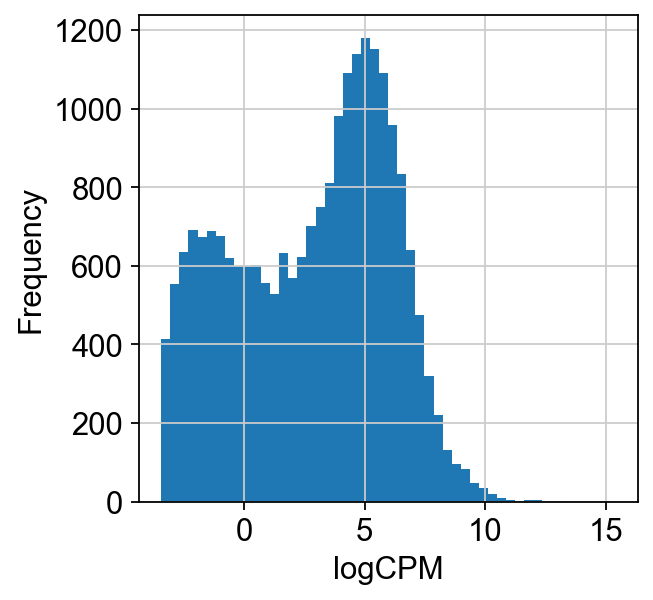

In [34]:
unique_logCPM = results.groupby("gene")["logCPM"].first()
plt.hist(unique_logCPM, bins=50, zorder=3)
plt.xlabel("logCPM")
plt.ylabel("Frequency")
plt.show()

In [35]:
# for marker genes, only use significant hits
results = results[results["FDR"] < fdr_threshold]

In [36]:
# drop bottom 50% logCPM genes per cell type
results = (
    results.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.5), "logCPM"))
    .reset_index(drop=True)
)
results = results.sort_values(by=["logFC"], ascending=[False])

In [37]:
ECs = results[results["cell_type"] == "ECs"]
ECs.head(20)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
20942,Ly6c1,Ly6c1,ECs,ECs_vs_others,11.483670,2863.711448,7.319307,2032.504689,0.0,0.0
20471,Slco1a4,Slco1a4,ECs,ECs_vs_others,11.331697,2577.393047,7.903313,3529.663678,0.0,0.0
21007,Adgrl4,Adgrl4,ECs,ECs_vs_others,11.253849,2442.002996,7.251852,9250.540868,0.0,0.0
20060,Flt1,Flt1,ECs,ECs_vs_others,11.222041,2388.751990,9.105710,2386.611793,0.0,0.0
21031,Cldn5,Cldn5,ECs,ECs_vs_others,11.102612,2198.969207,7.228749,1885.052649,0.0,0.0
22679,Ly6a,Ly6a,ECs,ECs_vs_others,11.079200,2163.572809,6.246103,2230.178034,0.0,0.0
24184,Cdh5,Cdh5,ECs,ECs_vs_others,10.696734,1659.731300,5.589945,7540.852250,0.0,0.0
22170,Mecom,Mecom,ECs,ECs_vs_others,10.629952,1584.653443,6.494315,6814.803503,0.0,0.0
23304,Cyyr1,Cyyr1,ECs,ECs_vs_others,10.181572,1161.337888,5.956397,4692.229519,0.0,0.0
24660,Zfp366,Zfp366,ECs,ECs_vs_others,10.040131,1052.884119,5.400319,14345.840054,0.0,0.0


In [38]:
ECs[ECs.gene.isin(["Cdh5", "Cldn5", "Nos3", "Foxf2", "Kdr"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
21031,Cldn5,Cldn5,ECs,ECs_vs_others,11.102612,2198.969207,7.228749,1885.052649,0.0,0.0
24184,Cdh5,Cdh5,ECs,ECs_vs_others,10.696734,1659.731300,5.589945,7540.852250,0.0,0.0
25300,Kdr,Kdr,ECs,ECs_vs_others,9.153933,569.650274,5.139114,5238.928612,0.0,0.0


In [39]:
pericytes = results[results["cell_type"] == "Pericytes"]
pericytes.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
103677,Higd1b,Higd1b,Pericytes,Pericytes_vs_others,12.143958,4525.801678,6.276022,6125.744023,0.000000e+00,0.000000e+00
103247,Abcc9,Abcc9,Pericytes,Pericytes_vs_others,11.423404,2746.548385,6.510440,9435.511085,0.000000e+00,0.000000e+00
102786,Slc38a11,Slc38a11,Pericytes,Pericytes_vs_others,11.048340,2117.785092,6.805448,6495.652885,0.000000e+00,0.000000e+00
105303,Ndufa4l2,Ndufa4l2,Pericytes,Pericytes_vs_others,10.609065,1561.876613,5.479613,23794.144089,0.000000e+00,0.000000e+00
104294,Tbx3os1,Tbx3os1,Pericytes,Pericytes_vs_others,10.276880,1240.649723,5.959222,11359.937646,0.000000e+00,0.000000e+00
102396,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.151450,1137.341373,7.085188,3761.612628,0.000000e+00,0.000000e+00
101310,Rgs5,Rgs5,Pericytes,Pericytes_vs_others,9.847938,921.562157,9.074663,1520.785370,0.000000e+00,0.000000e+00
102880,Slc6a20a,Slc6a20a,Pericytes,Pericytes_vs_others,9.517010,732.664853,6.747565,17016.072622,0.000000e+00,0.000000e+00
106352,Lamc3,Lamc3,Pericytes,Pericytes_vs_others,9.072658,538.446003,4.997837,16138.110755,0.000000e+00,0.000000e+00
102175,Adap2,Adap2,Pericytes,Pericytes_vs_others,9.015763,517.624858,7.285994,8157.994567,0.000000e+00,0.000000e+00


In [40]:
pericytes[pericytes.gene.isin(["Vtn", "Kcnj8", "Atp13a5"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
102396,Vtn,Vtn,Pericytes,Pericytes_vs_others,10.151450,1137.341373,7.085188,3761.612628,0.0,0.0
102039,Atp13a5,Atp13a5,Pericytes,Pericytes_vs_others,8.324319,320.530846,7.423538,8477.026198,0.0,0.0


In [41]:
SMCs = results[results["cell_type"] == "SMCs"]
SMCs.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
107248,Acta2,Acta2,SMCs,SMCs_vs_others,13.477576,11406.561503,7.463447,5866.414634,0.000000e+00,0.000000e+00
107784,Myh11,Myh11,SMCs,SMCs_vs_others,12.431087,5522.427325,6.984407,30986.831135,0.000000e+00,0.000000e+00
107578,Tagln,Tagln,SMCs,SMCs_vs_others,12.142414,4520.962928,7.157289,8309.931400,0.000000e+00,0.000000e+00
108047,Slc38a11,Slc38a11,SMCs,SMCs_vs_others,11.368510,2644.006770,6.805448,3323.509100,0.000000e+00,0.000000e+00
108995,Higd1b,Higd1b,SMCs,SMCs_vs_others,11.149651,2271.848550,6.276022,5562.278813,0.000000e+00,0.000000e+00
111605,Pln,Pln,SMCs,SMCs_vs_others,10.498969,1447.120276,5.075078,10496.990998,0.000000e+00,0.000000e+00
109271,Crispld2,Crispld2,SMCs,SMCs_vs_others,10.109459,1104.715203,6.131563,2299.844511,0.000000e+00,0.000000e+00
107148,Myl9,Myl9,SMCs,SMCs_vs_others,10.063834,1070.325487,7.586300,8822.662814,0.000000e+00,0.000000e+00
106546,Rgs5,Rgs5,SMCs,SMCs_vs_others,9.788574,884.411436,9.074663,3129.865890,0.000000e+00,0.000000e+00
111225,Rasl12,Rasl12,SMCs,SMCs_vs_others,9.462987,705.737297,5.247940,7424.780798,0.000000e+00,0.000000e+00


In [42]:
SMCs[SMCs.gene.isin(["Vtn", "Kcnj8"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
107656,Vtn,Vtn,SMCs,SMCs_vs_others,7.297143,157.274752,7.085188,2700.678487,0.0,0.0


In [43]:
oligos = results[results["cell_type"] == "Oligodendrocytes"]
oligos.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
98675,C030029H02Rik,C030029H02Rik,Oligodendrocytes,Oligodendrocytes_vs_others,10.016913,1036.075504,5.766228,8353.827039,0.0,0.0
100474,A330049N07Rik,A330049N07Rik,Oligodendrocytes,Oligodendrocytes_vs_others,10.001375,1024.976626,5.068062,4670.829137,0.0,0.0
95716,Fa2h,Fa2h,Oligodendrocytes,Oligodendrocytes_vs_others,9.807160,895.878795,7.402338,7846.273291,0.0,0.0
99148,A230001M10Rik,A230001M10Rik,Oligodendrocytes,Oligodendrocytes_vs_others,9.752781,862.739420,5.595805,5782.292958,0.0,0.0
95750,Ermn,Ermn,Oligodendrocytes,Oligodendrocytes_vs_others,9.645473,800.896988,7.370791,3884.372327,0.0,0.0
97210,Opalin,Opalin,Oligodendrocytes,Oligodendrocytes_vs_others,9.579572,765.135709,6.424240,5053.693990,0.0,0.0
98992,Enpp6,Enpp6,Oligodendrocytes,Oligodendrocytes_vs_others,9.505898,727.043629,5.649364,16777.192575,0.0,0.0
100989,Gm19500,Gm19500,Oligodendrocytes,Oligodendrocytes_vs_others,9.443962,696.491371,4.867881,12075.917458,0.0,0.0
94754,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.285746,624.148624,13.082013,2910.154003,0.0,0.0
95123,St18,St18,Oligodendrocytes,Oligodendrocytes_vs_others,9.181505,580.642013,8.308382,8205.354054,0.0,0.0


In [44]:
oligos[oligos.gene.isin(["Mbp", "Mag", "Plp1"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
94754,Plp1,Plp1,Oligodendrocytes,Oligodendrocytes_vs_others,9.285746,624.148624,13.082013,2910.154003,0.0,0.0
95328,Mag,Mag,Oligodendrocytes,Oligodendrocytes_vs_others,8.728022,424.029706,7.888243,3798.754991,0.0,0.0
94799,Mbp,Mbp,Oligodendrocytes,Oligodendrocytes_vs_others,6.382525,83.431784,10.010735,1836.241472,0.0,0.0


In [45]:
VLMCs = results[results["cell_type"] == "VLMCs"]
VLMCs.head(15)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
113953,Igf2,Igf2,VLMCs,VLMCs_vs_others,11.818102,3610.798507,6.450140,5641.803430,0.0,0.0
113845,Dcn,Dcn,VLMCs,VLMCs_vs_others,11.646986,3206.950284,6.507698,2014.589676,0.0,0.0
115844,Lama1,Lama1,VLMCs,VLMCs_vs_others,10.312927,1272.039106,5.517078,2862.665298,0.0,0.0
115071,Cemip,Cemip,VLMCs,VLMCs_vs_others,9.023788,520.512200,5.875260,3713.024910,0.0,0.0
116934,Lamc3,Lamc3,VLMCs,VLMCs_vs_others,9.002368,512.841092,4.997837,15155.780038,0.0,0.0
112041,Apod,Apod,VLMCs,VLMCs_vs_others,8.925354,486.182285,8.468805,3768.906240,0.0,0.0
112318,Pdgfra,Pdgfra,VLMCs,VLMCs_vs_others,8.875957,469.817625,7.837819,5273.797040,0.0,0.0
114750,Bgn,Bgn,VLMCs,VLMCs_vs_others,8.870381,468.005311,6.025494,4325.306301,0.0,0.0
113444,Slc6a20a,Slc6a20a,VLMCs,VLMCs_vs_others,8.859974,464.641563,6.747565,13853.074081,0.0,0.0
115216,Col1a2,Col1a2,VLMCs,VLMCs_vs_others,8.774992,438.062360,5.800668,5504.428717,0.0,0.0


In [46]:
astro = results[results["cell_type"] == "Astrocytes"]
astro.head(25)

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
8808,Atp13a4,Atp13a4,Astrocytes,Astrocytes_vs_others,8.737793,426.911509,5.016709,10959.757148,0.0,0.0
6956,Gm12239,Gm12239,Astrocytes,Astrocytes_vs_others,8.159461,285.918621,5.758235,1826.878570,0.0,0.0
8226,Etnppl,Etnppl,Astrocytes,Astrocytes_vs_others,7.887357,236.772454,5.250214,2519.584601,0.0,0.0
6628,Gm6145,Gm6145,Astrocytes,Astrocytes_vs_others,7.887258,236.756076,5.915359,3667.169475,0.0,0.0
5110,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.846095,230.096517,6.647229,2460.382354,0.0,0.0
9450,Eva1a,Eva1a,Astrocytes,Astrocytes_vs_others,7.830638,227.644347,4.744779,8332.051958,0.0,0.0
8610,Agt,Agt,Astrocytes,Astrocytes_vs_others,7.693021,206.933106,5.097640,1641.573008,0.0,0.0
5605,Slc39a12,Slc39a12,Astrocytes,Astrocytes_vs_others,7.643220,199.911867,6.382005,4510.965967,0.0,0.0
4564,Slco1c1,Slco1c1,Astrocytes,Astrocytes_vs_others,7.614007,195.904564,6.989064,3888.599979,0.0,0.0
8281,Gm20713,Gm20713,Astrocytes,Astrocytes_vs_others,7.567177,189.647599,5.228550,3909.462070,0.0,0.0


In [47]:
astro[astro.gene.isin(["Aqp4", "Gfap", "Htra1", "Aldoc"])]

,Unnamed: 0,gene,cell_type,test,logFC,FC,logCPM,LR,PValue,FDR
5110,Aqp4,Aqp4,Astrocytes,Astrocytes_vs_others,7.846095,230.096517,6.647229,2460.382354,0.0,0.0
9682,Gfap,Gfap,Astrocytes,Astrocytes_vs_others,6.412954,85.210210,4.638802,1644.934811,0.0,0.0
4453,Htra1,Htra1,Astrocytes,Astrocytes_vs_others,5.887710,59.207565,7.069867,3135.511025,0.0,0.0
3775,Aldoc,Aldoc,Astrocytes,Astrocytes_vs_others,5.000814,32.018054,7.763579,1879.259854,0.0,0.0
